# 

# Data Partionning
## 1. Rearranging Columns per 
This step requires us to partition the data and further clean it before we are ready to train

In [1]:
import os
import glob
import pandas as pd
from pathlib import Path as path
import featuretools as ft
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import RFECV, VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, precision_score, recall_score, roc_auc_score)
from sklearn.model_selection import StratifiedKFold, train_test_split

In order to simplify repertory changes, we'll initialize two variables, containning the paths of this current repository and the path of your clone of the Apache Hive repertory.

In [2]:
project_repo = path("/home/nicolas-richard/Desktop/.Apache_Hive_Bug_Prediction_ML_Model")
hive_repo = path("/home/nicolas-richard/Desktop/.Apache_Hive")

In [3]:
def extract_version(filename):
    file_part = filename.split('/')[-1]

    parts = file_part.split('-')
    if len(parts) < 2:
        raise ValueError("Filename does not contain a version segment.")

    version_part = parts[1].split('_')[0]
    return version_part

In [4]:
input_files = glob.glob(os.path.join(project_repo, 'UND_hive_updated_data', '*.csv'))

concatenated_df = pd.DataFrame()

for file in input_files:
    df = pd.read_csv(file)
    
    version = extract_version(file)
    df.insert(loc=2, column='Version', value=version)
    concatenated_df = pd.concat([concatenated_df, df], ignore_index=True)

concatenated_df.info()
count = concatenated_df['Version'].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147744 entries, 0 to 147743
Data columns (total 100 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Bug                                 147744 non-null  int64  
 1   FileName                            147744 non-null  object 
 2   Version                             147744 non-null  object 
 3   AvgCountLine                        147744 non-null  float64
 4   AvgCountLineBlank                   147744 non-null  float64
 5   AvgCountLineCode                    147744 non-null  float64
 6   AvgCountLineComment                 147744 non-null  float64
 7   AvgCyclomatic                       147744 non-null  float64
 8   AvgCyclomaticModified               147744 non-null  float64
 9   AvgCyclomaticStrict                 147744 non-null  float64
 10  AvgCyclomaticStrictModified         147744 non-null  float64
 11  AvgEssential             

In [5]:
print(concatenated_df['Version'].nunique())
concatenated_df.info()

23
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147744 entries, 0 to 147743
Data columns (total 100 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Bug                                 147744 non-null  int64  
 1   FileName                            147744 non-null  object 
 2   Version                             147744 non-null  object 
 3   AvgCountLine                        147744 non-null  float64
 4   AvgCountLineBlank                   147744 non-null  float64
 5   AvgCountLineCode                    147744 non-null  float64
 6   AvgCountLineComment                 147744 non-null  float64
 7   AvgCyclomatic                       147744 non-null  float64
 8   AvgCyclomaticModified               147744 non-null  float64
 9   AvgCyclomaticStrict                 147744 non-null  float64
 10  AvgCyclomaticStrictModified         147744 non-null  float64
 11  AvgEssential          

In [26]:
concatenated_df.drop_duplicates
data = concatenated_df.iloc[:,[0,7,8,9,11,3,4,5,6,20,21,22,27,28,29,33,36,38,39,
                               40,42,43,44,45,46,47,53,54,55,57,64,65,66,75,76,
                               77,78,80,16,17,19,70,73,82,83,84,85,86,87,88,89,
                               90,91,92,93]]
data.dropna(inplace=True)
data = data.reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147340 entries, 0 to 147339
Data columns (total 55 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Bug                        147340 non-null  int64  
 1   AvgCyclomatic              147340 non-null  float64
 2   AvgCyclomaticModified      147340 non-null  float64
 3   AvgCyclomaticStrict        147340 non-null  float64
 4   AvgEssential               147340 non-null  float64
 5   AvgCountLine               147340 non-null  float64
 6   AvgCountLineBlank          147340 non-null  float64
 7   AvgCountLineCode           147340 non-null  float64
 8   AvgCountLineComment        147340 non-null  float64
 9   CountDeclClass             147340 non-null  float64
 10  CountDeclClassMethod       147340 non-null  float64
 11  CountDeclClassVariable     147340 non-null  float64
 12  CountDeclFunction          147340 non-null  float64
 13  CountDeclInstanceMethod    14

We now have 55 columns. This includes all the *46 independent variables* at study (37 related to files, 5 related to classes and 4 related to methods (expanded to 12 for simplicity's sake) mentionned in *Yatish et al., 2019*) in addition to the first column, specify whether there is a bug in a given file. The dataframe is structured as follows

In [27]:
data.tail()

,Bug,AvgCyclomatic,AvgCyclomaticModified,AvgCyclomaticStrict,AvgEssential,AvgCountLine,AvgCountLineBlank,AvgCountLineCode,AvgCountLineComment,CountDeclClass,...,CountInputMax,CountOutputMin,CountOutputMean,CountOutputMax,CountPathMin,CountPathMean,CountPathMax,MaxNestingMin,MaxNestingMean,MaxNestingMax
147335,0,2.0,2.0,2.0,1.0,12.0,0.0,12.0,0.0,2.0,...,5.0,2.0,9.00,17.0,1.0,1.5,2.0,0.0,0.5,1.0
147336,0,2.0,2.0,2.0,1.0,12.0,0.0,12.0,0.0,2.0,...,4.0,2.0,9.00,17.0,1.0,1.5,2.0,0.0,0.5,1.0
147337,0,2.0,2.0,2.0,1.0,24.0,3.0,16.0,6.0,1.0,...,7.0,2.0,4.25,7.0,1.0,2.5,4.0,0.0,1.0,2.0
147338,0,2.0,2.0,2.0,1.0,10.0,2.0,8.0,0.0,2.0,...,4.0,5.0,5.00,5.0,1.0,1.0,1.0,0.0,0.0,0.0
147339,0,1.0,1.0,1.0,1.0,5.0,0.0,5.0,0.0,1.0,...,5.0,1.0,2.75,5.0,1.0,1.5,2.0,0.0,0.5,1.0


# 2. Analyse et Amélioration des Données
## 2.1 Vérifier la Qualité des Données

Des valeurs extrêmes peuvent biaiser les modèles tandis que des étiquettes incorrectes peuvent nuire à l'apprentissage du modèle.

ValueError: num must be 1 <= num <= 40, not 41

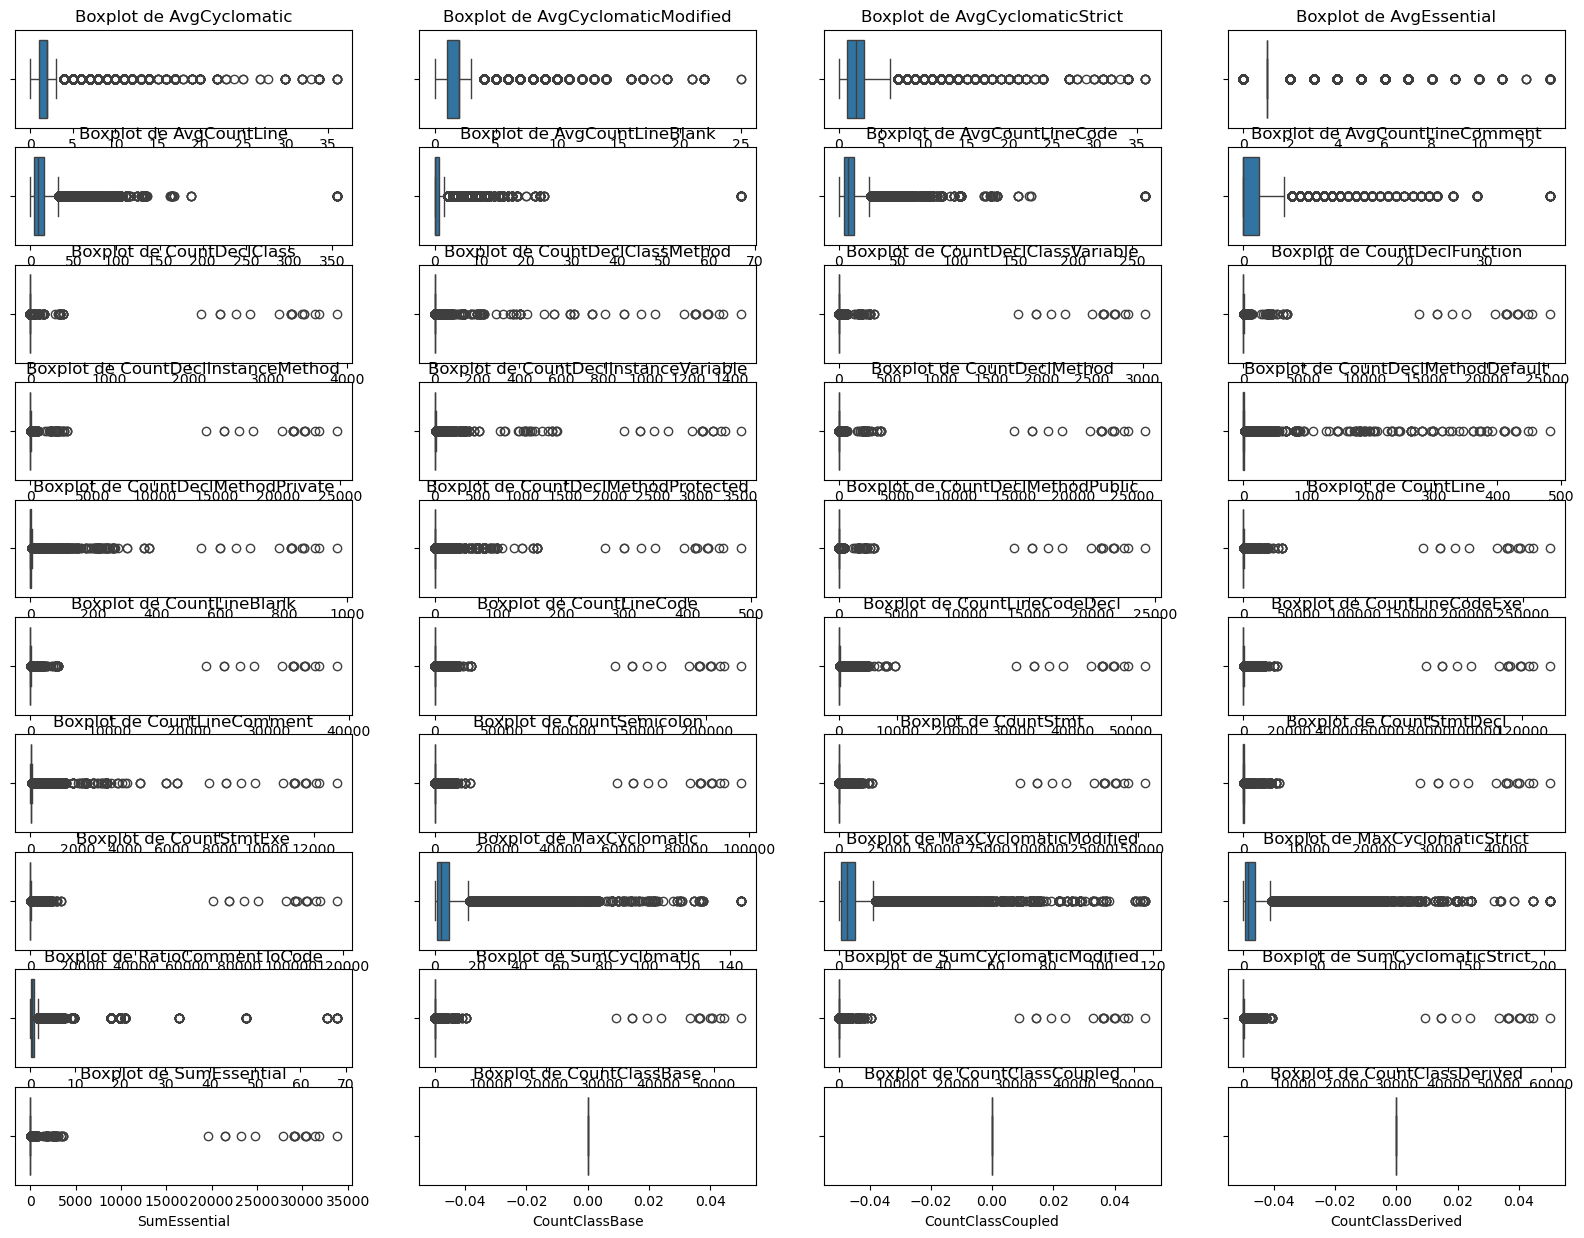

In [28]:
numeric_features = data.select_dtypes(include=['float64']).columns.tolist()
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(10, 4, i)
    sns.boxplot(x=data[feature])
    plt.title(f'Boxplot de {feature}')
plt.tight_layout()
plt.show()